## Comparativas

Este cuaderno se centra en hacer estudio comparativo sobre una simulación base, generalmente realizando un análisis *ceteris paribus* sobre una variable de interés.

In [1]:
# Configurar entorno Jupyter
%config Completer.use_jedi = False

# Importar librerías
import numpy as np
import matplotlib.pyplot as plt
import sys, os
import time
from datetime import datetime
from IPython.display import display, clear_output

# Importar pyhelios
PYHELIOS_LIB_PATH = '/home/uadmin/git/helios/cmake-build-release'
HELIOS_PATH = '/home/uadmin/git/helios'
sys.path.append(PYHELIOS_LIB_PATH)
sys.path.append(HELIOS_PATH)
if os.getcwd().endswith('pyhelios'):
    os.chdir(os.path.dirname(os.getcwd()))
import pyhelios

### Generar XML para la simulación base

Para comenzar, se genera una simulación base con XML temporales.

In [2]:
# Ruta al directorio temporal donde se exportarán los XML
tmpdir = os.path.join(os.getcwd(), 'tmpdir')
tmp_scene_xml = os.path.join(tmpdir, 'scene.xml')
tmp_survey_xml = os.path.join(tmpdir, 'survey.xml')
# XML de escena
SCENE_XML = \
'''
<?xml version="1.0" encoding="UTF-8"?>
<document>
<scene id="scene" name="scene">
    <part>
        <filter type="objloader">
            <param type="string" key="filepath" value="helios_asset/sceneparts/box100.obj" />
        </filter>
    </part>
</scene>
</document>
'''
os.makedirs(tmpdir, exist_ok=True)
with open(tmp_scene_xml, 'w') as scene_file:
    scene_file.write(SCENE_XML)
# XML de simulación
SURVEY_XML = \
f'''
<?xml version="1.0" encoding="UTF-8"?>
<document>
<survey name="tls_toyblocks_livox" scene="{tmp_scene_xml}#scene" platform="helios_asset/platforms.xml#simple_linearpath" scanner="helios_asset/scanners_tls.xml#livox_mid-70">        
    <FWFSettings binSize_ns="0.2" beamSampleQuality="3" />
    <leg>    
        <platformSettings x="-10.01" y="-15.0" z="0.0" movePerSec_m="0.05" />
        <scannerSettings active="true" scanAngle_deg="35" pulseFreq_hz="100000" headRotatePerSec_deg="0" trajectoryTimeInterval_s="0.01" />
    </leg>
    <leg>
        <platformSettings x="-10.0" y="-15.0" z="0.0" movePerSec_m="0.05" />
        <scannerSettings active="false" scanAngle_deg="35" pulseFreq_hz="100000" headRotatePerSec_deg="0" />
    </leg>
</survey>
</document>
'''
os.makedirs(tmpdir, exist_ok=True)
with open(tmp_survey_xml, 'w') as survey_file:
    survey_file.write(SURVEY_XML)

### Ejecutar simulaciones

A continuación, se realizarán varias simulaciones sobre la misma base, modificando la velocidad de la plataforma.

In [3]:
# Cargar simulación base
root_dir = os.getcwd()
out_dir = os.path.join(root_dir, 'output/pyhelios/comparativa_ejemplo')
sim_builder = pyhelios.SimulationBuilder(
    tmp_survey_xml,
    os.path.join(root_dir, 'helios_asset/'),
    out_dir
)
print(f'Cargada simulacion desde: "{tmp_survey_xml}"')

# Configurar las nubes sintéticas para que tengan formato LAZ (LAS comprimido)
sim_builder.setLasOutput(True)
sim_builder.setZipOutput(True)

# Construir la simulación
sim1 = sim_builder.build()

# Construir segunda simulación
sim2 = sim1.copy()
sim2.sim.getLeg(0).getPlatformSettings().movePerSec = 0.01

# Construir tercera simulación
sim3 = sim1.copy()
sim3.sim.getLeg(0).getPlatformSettings().movePerSec = 0.005

# Ejecutar las simulaciones
sim = [sim1, sim2, sim3]
start = time.perf_counter()
out = []
for simi in sim:
    simi.start()
    out.append(simi.join())
end = time.perf_counter()
print(f'Las simulaciones se han ejecutado en {end-start:.3f} segundos.')

# Extraer información de interés
P, T = [], []
for outi in out:
    Pi, Ti = pyhelios.outputToNumpy(outi)
    P.append(Pi)
    T.append(Ti)

surveyPath: "/home/uadmin/git/vlsdl_workshop2024/tmpdir/survey.xml"
Cargada simulacion desde: "/home/uadmin/git/vlsdl_workshop2024/tmpdir/survey.xml"
SimulationBuilder is building simulation ...
SimulationBuilder built simulation in 0.006823384999734117 seconds
Las simulaciones se han ejecutado en 0.619 segundos.


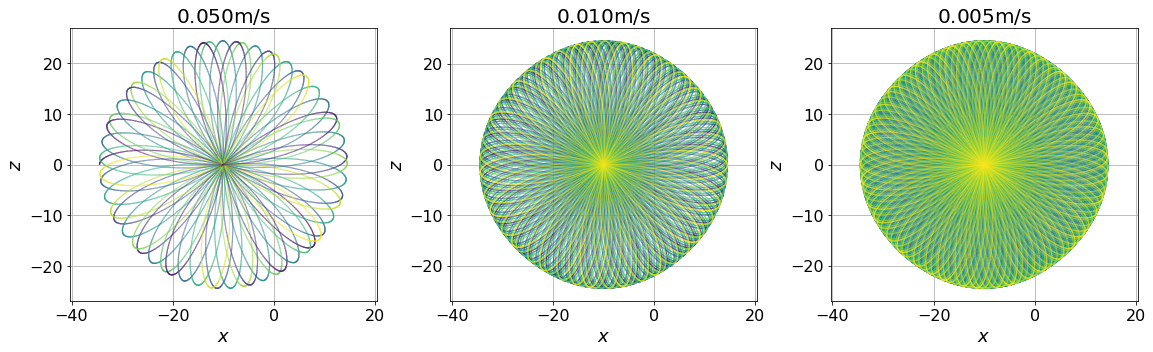

In [4]:
# Preparar contexto de graficación
fig = plt.figure(figsize=(16, 5))

for i in range(len(out)):
    # Graficar puntos de las nubes sintéticas
    ax = fig.add_subplot(1, 3, 1+i)
    ax.scatter(P[i][:, 0], P[i][:, 2], c=P[i][:, -1], s=0.05, cmap='viridis')
    # Configurar figura
    ax.set_title(
        f'${sim[i].sim.getLeg(0).getPlatformSettings().movePerSec:.3f} \mathrm{{m}}/\\mathrm{{s}}$',
        fontsize=20
    )
    ax.set_xlabel('$x$', fontsize=18)
    ax.set_ylabel('$z$', fontsize=18)
    ax.grid('both')
    ax.set_axisbelow(True)
    ax.tick_params(axis='both', which='both', labelsize=16)
    ax.axis('equal')    

# Mostrar gráfico
fig.tight_layout()
plt.show()

### Ejercicio 1

Crear una simulación base con un plano de suelo y una plataforma aérea lineal usando un $\text{RIEGL VUX-1UAV}^{22}$. Generar 64 variaciones de la simulación explorando la altitud de vuelo en el intervalo $[30, 120]$ metros. Con los datos resultantes graficar:

1. Una visualización 2D de 9 planos de suelo $(x, y)$, cubriendo los casos 1, 8, 16, 24, 32, 40, 48, 56, 64.
2. Graficar el el área escaneada y la densidad de superficie (puntos por metro cuadrado) como función de la altura de vuelo.

In [5]:
# TODO : Codifíquese aquí la respuesta al Ejercicio 1

### Ejercicio 2

Considerar el ejercicio 3 del bloque HELIOS básico como simulación base. Realizar 16 variaciones respecto de la velocidad de la plataforma entre los en $0.5\;\mathrm{m}/\mathrm{s}$ y los $20\;\mathrm{m}\mathrm{s}$. Con los datos resultantes graficar:

1. Una visualización 2D mostrando las plantas de trigo como $z(y)$ (no mostrar puntos que no sean de maíz, es decir, no representar el suelo).

2. Graficar el número de puntos de trigo como función de la velocidad en $\mathrm{km}/\mathrm{h}$

In [6]:
# TODO : Codifíquese aquí la respuesta al Ejercicio 2

### Solución : Ejercicio 1

In [7]:
# Ruta al directorio temporal donde se exportarán los XML
tmpdir = os.path.join(os.getcwd(), 'tmpdir')
tmp_platform_xml = os.path.join(tmpdir, 'platform.xml')
tmp_scene_xml = os.path.join(tmpdir, 'scene.xml')
tmp_survey_xml = os.path.join(tmpdir, 'survey.xml')
PLATFORM_XML = \
'''
<?xml version="1.0" encoding="UTF-8"?>
<document>
<platform id="ovni" name="Objeto volador no identificado" type="linearpath">
    <scannerMount z="0">
        <rot axis="x" angle_deg="180" />
    </scannerMount>
</platform>
</document>
'''
os.makedirs(tmpdir, exist_ok=True)
with open(tmp_platform_xml, 'w') as platform_file:
    platform_file.write(PLATFORM_XML)
# XML de escena
SCENE_XML = \
'''
<?xml version="1.0" encoding="UTF-8"?>
<document>
<scene id="scene" name="scene">
    <part>
        <filter type="objloader">
            <param type="string" key="filepath" value="helios_asset/sceneparts/groundplane.obj" />
        </filter>
        <filter type="scale">
            <param type="double" key="scale" value="300" />
        </filter>
    </part>
</scene>
</document>
'''
os.makedirs(tmpdir, exist_ok=True)
with open(tmp_scene_xml, 'w') as scene_file:
    scene_file.write(SCENE_XML)
# XML de simulación
SURVEY_XML = \
f'''
<?xml version="1.0" encoding="UTF-8"?>
<document>
<survey name="als_ground" scene="{tmp_scene_xml}#scene" platform="{tmp_platform_xml}#ovni" scanner="helios_asset/scanners_als.xml#riegl_vux-1uav22">        
    <FWFSettings binSize_ns="0.2" beamSampleQuality="1" />
    <leg>    
        <platformSettings x="-50.00" y="0.0" z="30.0" movePerSec_m="8.0" />
        <scannerSettings active="true" scanAngle_deg="30" scanFreq_hz="100" pulseFreq_hz="100000" trajectoryTimeInterval_s="0.01" />
    </leg>
    <leg>
        <platformSettings x="50.0" y="0.0" z="30.0" movePerSec_m="8.0" />
        <scannerSettings active="false" scanAngle_deg="30" scanFreq_hz="100" pulseFreq_hz="100000" trajectoryTimeInterval_s="0.01" />
    </leg>
</survey>
</document>
'''
os.makedirs(tmpdir, exist_ok=True)
with open(tmp_survey_xml, 'w') as survey_file:
    survey_file.write(SURVEY_XML)

In [8]:
# Cargar simulación base
root_dir = os.getcwd()
out_dir = os.path.join(root_dir, 'output/pyhelios/comparativa_suelo')
sim_builder = pyhelios.SimulationBuilder(
    tmp_survey_xml,
    os.path.join(root_dir, 'helios_asset/'),
    out_dir
)
print(f'Cargada simulacion desde: "{tmp_survey_xml}"')

# Configurar las nubes sintéticas para que tengan formato LAZ (LAS comprimido)
sim_builder.setLasOutput(True)
sim_builder.setZipOutput(True)

# Construir la simulación
sim1 = sim_builder.build()

# Generar variaciones de la simulación
sim = [sim1]
for i in range(63):
    simi = sim1.copy()
    sim.append(simi)    
zmin, zmax = 30, 120
zstep = (zmax-zmin)/63.0
for i, simi in enumerate(sim):
    for j in range(simi.sim.getNumLegs()):
        simi.sim.getLeg(j).getPlatformSettings().z = zmin+i*zstep

# Ejecutar las simulaciones
start = time.perf_counter()
out = []
for simi in sim:
    simi.start()
    out.append(simi.join())
end = time.perf_counter()
print(f'Las {len(sim)} simulaciones se han ejecutado en {end-start:.3f} segundos.')

# Extraer información de interés
P, T = [], []
for outi in out:
    Pi, Ti = pyhelios.outputToNumpy(outi)
    P.append(Pi)
    T.append(Ti)

surveyPath: "/home/uadmin/git/vlsdl_workshop2024/tmpdir/survey.xml"
Cargada simulacion desde: "/home/uadmin/git/vlsdl_workshop2024/tmpdir/survey.xml"
SimulationBuilder is building simulation ...
SimulationBuilder built simulation in 0.006055620999177336 seconds
Las 64 simulaciones se han ejecutado en 17.720 segundos.


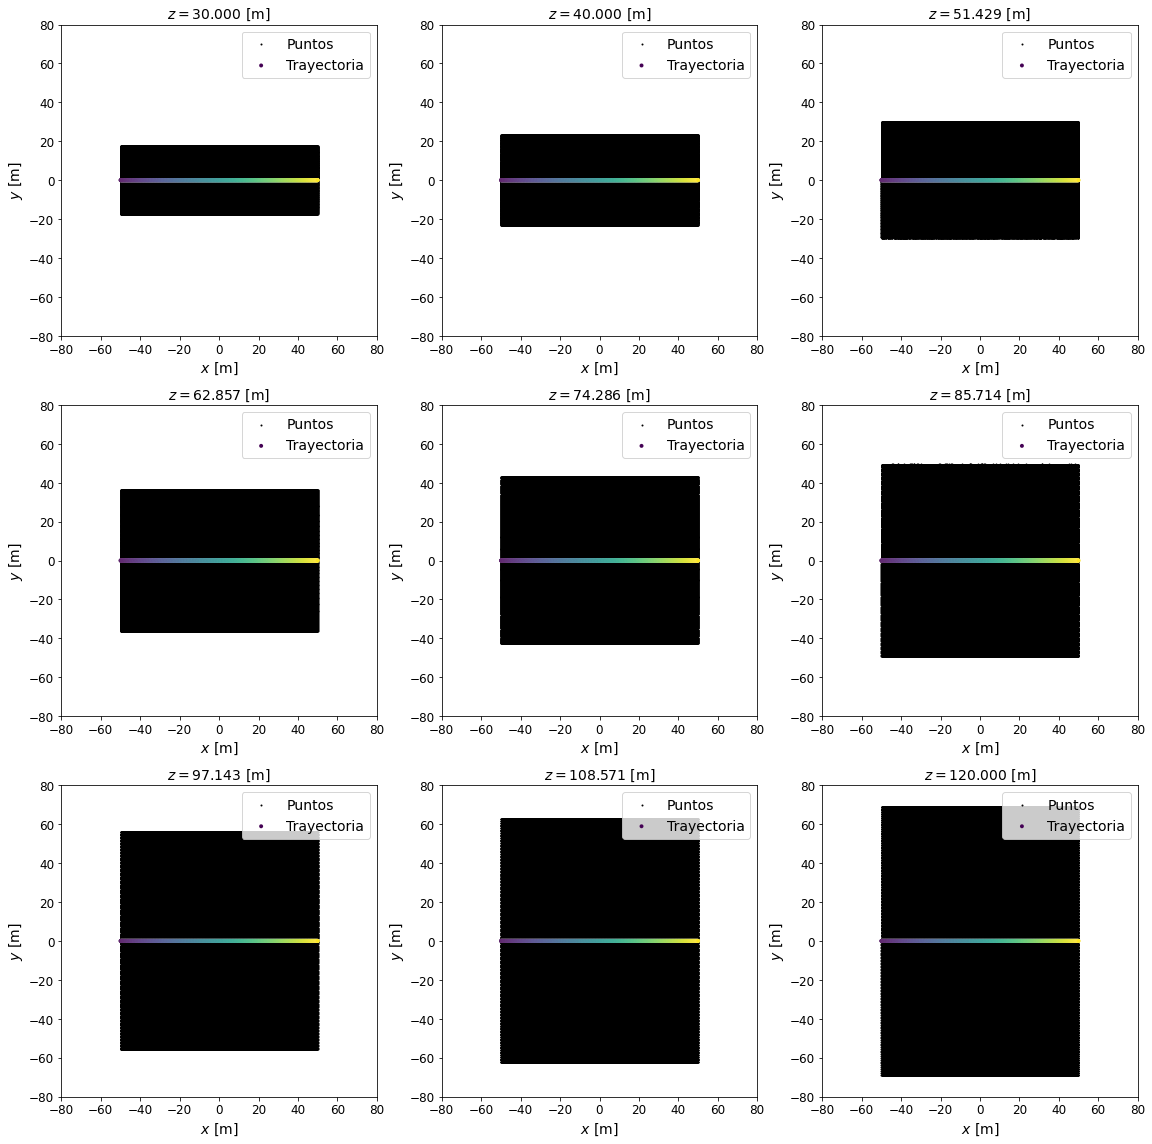

In [9]:
# Preparar contexto de graficación
fig = plt.figure(figsize=(16, 16))

# Graficar trigales
for k, i in enumerate([0] + [i*8-1 for i in range(1, 9)]):
    Pi = P[i]
    ax = fig.add_subplot(3, 3, 1+k)
    ax.scatter(Pi[:, 0], Pi[:, 1], color='black', s=1, zorder=3, label='Puntos')
    ax.scatter(
        Ti[:, 0], Ti[:, 1], c=Ti[:, 3], s=16, cmap='viridis',
        edgecolor='white', linewidths=0.05, zorder=4, label='Trayectoria'
    )
    ax.set_xlabel('$x$ [m]', fontsize=14)
    ax.set_ylabel('$y$ [m]', fontsize=14)
    ax.tick_params(axis='both', which='both', labelsize=12)
    zi = sim[i].sim.getLeg(0).getPlatformSettings().z
    ax.set_title(f'$z = {zi:.3f}$ [m]', fontsize=14)
    ax.set_xlim(-80, 80)
    ax.set_ylim(-80, 80)
    ax.legend(loc='upper right', fontsize=14)
    
# Mostrar gráfico
fig.tight_layout()
plt.show()

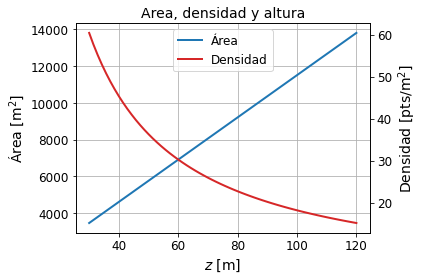

In [10]:
# Preparar contexto de graficación
fig = plt.figure(figsize=(6, 4))

# Graficar área y densidad de superficie como función de z
z, area, surf_dens = [], [], []
for i in range(len(out)):
    Pi = P[i]
    a, b = np.min(Pi[:, :2], axis=0), np.max(Pi[:, :2], axis=0)
    D = b-a
    area.append(D[0]*D[1])
    surf_dens.append(Pi.shape[0]/area[-1])
    z.append(sim[i].sim.getLeg(0).getPlatformSettings().z)
ax = fig.add_subplot(1, 1, 1)
plot_area = ax.plot(z, area, lw=2, color='tab:blue', label='Área')
ax.set_title('Area, densidad y altura', fontsize=14)
ax.set_xlabel(r'$z$ [$\mathrm{m}$]', fontsize=14)
ax.set_ylabel(r'Área [$\mathrm{m}^2$]', fontsize=14)
ax.grid('both')
ax.set_axisbelow(True)
ax.tick_params(axis='both', which='both', labelsize=12)
ax2 = ax.twinx()
plot_dens = ax2.plot(z, surf_dens, lw=2, color='tab:red', label='Densidad')
ax2.set_ylabel(r'Densidad [$\mathrm{pts}/\mathrm{m}^2$]', fontsize=14)
ax2.set_axisbelow(True)
ax2.tick_params(axis='y', which='both', labelsize=12)
ax.legend(loc='upper center', fontsize=12)
plots = plot_area + plot_dens
legends = [plot.get_label() for plot in plots]
ax.legend(plots, legends, loc='upper center', fontsize=12)

# Mostrar gráfico
fig.tight_layout()
plt.show()

### Solución : Ejercicio 2

In [11]:
# Cargar simulación MLS básica
root_dir = os.getcwd()
out_dir = os.path.join(root_dir, 'output/pyhelios/')
sim_builder = pyhelios.SimulationBuilder(
    os.path.join(root_dir, 'helios_basico/mls_lineal/soluciones/ejercicio3/simulacion_mls_lineal_ejercicio3.xml'),
    os.path.join(root_dir, 'helios_asset/'),
    out_dir
)

# Configurar las nubes sintéticas para que tengan formato LAZ (LAS comprimido)
sim_builder.setLasOutput(True)
sim_builder.setZipOutput(True)

# Construir la simulación base
start = time.perf_counter()
sim1 = sim_builder.build()

# Generar variaciones de la simulación
sim = [sim1]
for i in range(15):
    simi = sim1.copy()
    sim.append(simi)    
vmin, vmax = 0.5, 20.0
vstep = (vmax-vmin)/15.0
for i, simi in enumerate(sim):
    for j in range(simi.sim.getNumLegs()):
        simi.sim.getLeg(j).getPlatformSettings().movePerSec = vmin+i*vstep
        
# Reportar tiempo de construcción de simulaciones
end = time.perf_counter()
print(f'{len(sim)} simulaciones construidas en {end-start:.3f} segundos.')

# Ejecutar las simulaciones
start = time.perf_counter()
out = []
for simi in sim:
    simi.start()
    out.append(simi.join())
end = time.perf_counter()
print(f'Las {len(sim)} simulaciones se han ejecutado en {end-start:.3f} segundos.')

# Extraer información de interés
P, T = [], []
for outi in out:
    Pi, Ti = pyhelios.outputToNumpy(outi)
    P.append(Pi)
    T.append(Ti)

surveyPath: "/home/uadmin/git/vlsdl_workshop2024/helios_basico/mls_lineal/soluciones/ejercicio3/simulacion_mls_lineal_ejercicio3.xml"
SimulationBuilder is building simulation ...
SimulationBuilder built simulation in 4.720254907999333 seconds
16 simulaciones construidas en 4.758 segundos.
Las 16 simulaciones se han ejecutado en 23.403 segundos.


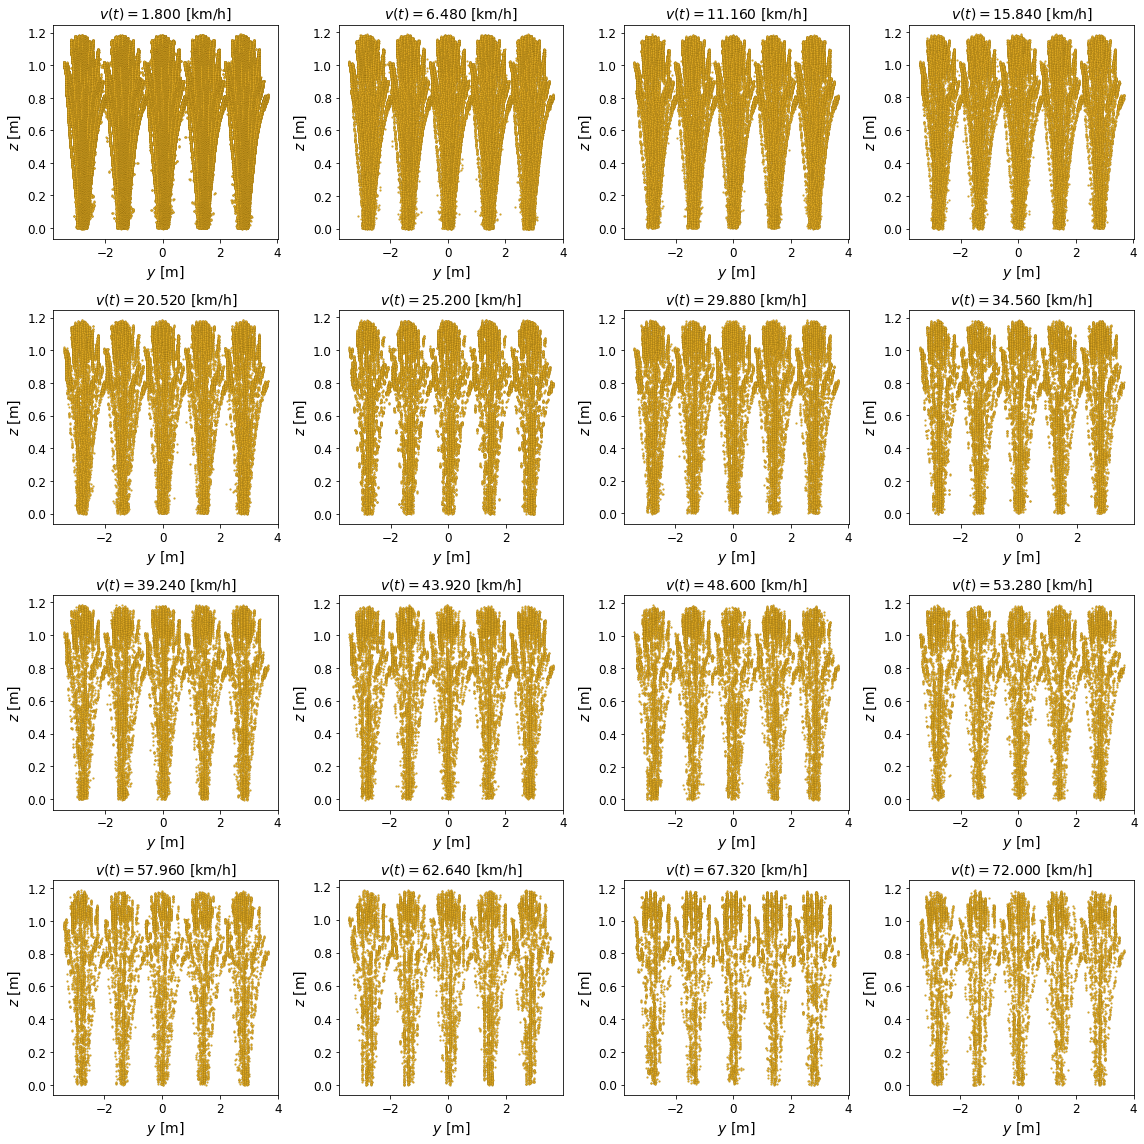

In [12]:
# Preparar contexto de graficación
fig = plt.figure(figsize=(16, 16))

# Graficar trigales
for i in range(len(out)):
    Pi = P[i]
    wheat_mask = Pi[:, 14] > 0
    Pi = Pi[wheat_mask]
    ax = fig.add_subplot(4, 4, 1+i)
    ax.scatter(Pi[:, 1], Pi[:, 2], color='goldenrod', s=4, edgecolor='black', linewidths=0.05)
    ax.set_xlabel('$y$ [m]', fontsize=14)
    ax.set_ylabel('$z$ [m]', fontsize=14)
    ax.tick_params(axis='both', which='both', labelsize=12)
    vi = sim[i].sim.getLeg(0).getPlatformSettings().movePerSec/1000*3600
    ax.set_title(f'$v(t) = {vi:.3f}$ [km/h]', fontsize=14)
    
# Mostrar gráfico
fig.tight_layout()
plt.show()

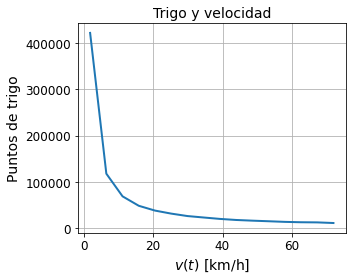

In [13]:
# Preparar contexto de graficación
fig = plt.figure(figsize=(5, 4))

# Graficar número de puntos de trigo como función de la velocidad
m, v = [], []
for i in range(len(out)):
    Pi = P[i]
    m.append(np.count_nonzero(Pi[:, 14] > 0))
    v.append(sim[i].sim.getLeg(0).getPlatformSettings().movePerSec/1000*3600)
ax = fig.add_subplot(1, 1, 1)
ax.plot(v, m, lw=2, color='tab:blue')
ax.set_title('Trigo y velocidad', fontsize=14)
ax.set_xlabel(f'$v(t)$ [km/h]', fontsize=14)
ax.set_ylabel('Puntos de trigo', fontsize=14)
ax.grid('both')
ax.set_axisbelow(True)
ax.tick_params(axis='both', which='both', labelsize=12)

    
# Mostrar gráfico
fig.tight_layout()
plt.show()